In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 99% 119M/121M [00:08<00:00, 19.7MB/s]
100% 121M/121M [00:08<00:00, 15.2MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dense, MaxPooling2D, Activation,Dropout

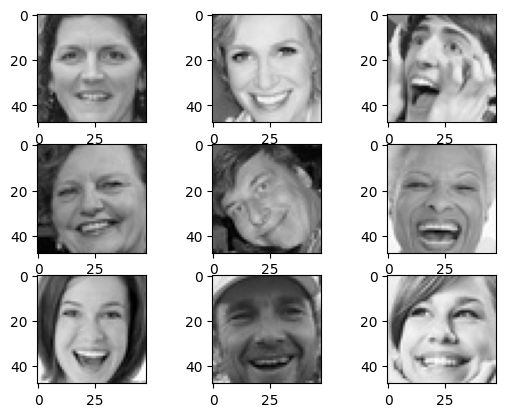

In [7]:
pic_size = 48
folder_path = "/content/images"

expression = 'happy'
plt.figure()
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path + '/train/' + expression + '/' + 
                   os.listdir(folder_path + '/train/' +expression)[i], 
                   target_size = (pic_size, pic_size))
    plt.imshow(img)
plt.show()

In [11]:
batch_size = 128
data_train = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
data_test = ImageDataGenerator(
    rescale=1./255
)

train_set = data_train.flow_from_directory(folder_path+"/train",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)
test_set = data_test.flow_from_directory(folder_path+"/validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [12]:
no_of_classes = 7
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(256,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./myfermodel_e11.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [14]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list)

<ipython-input-14-9886a6645606>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.9599 - accuracy: 0.2440

225/225 [==============================] - 42s 124ms/step - loss: 1.9599 - accuracy: 0.2440 - val_loss: 2.1388 - val_accuracy: 0.2592 - lr: 0.0010
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.6486 - accuracy: 0.3627

225/225 [==============================] - 29s 129ms/step - loss: 1.6486 - accuracy: 0.3627 - val_loss: 1.8036 - val_accuracy: 0.3104 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.4840 - accuracy: 0.4325

225/225 [==============================] - 29s 130ms/step - loss: 1.4840 - accuracy: 0.4325 - val_loss: 1.5474 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.4744

225/225 [==============================] - 27s 120ms/step - loss: 1.3666 - accuracy: 0.4744 - val_loss: 1.3353 - val_accuracy: 0.4866 - lr: 0.0010
Epoch 5/48
225/225 [==============================] - ETA: 0s - loss: 1.3051 - accuracy: 0.5027

225/225 [==============================] - 28s 123ms/step - loss: 1.3051 - accuracy: 0.5027 - val_loss: 1.2427 - val_accuracy: 0.5332 - lr: 0.0010
Epoch 6/48
225/225 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.5200

225/225 [==============================] - 27s 120ms/step - loss: 1.2601 - accuracy: 0.5200 - val_loss: 1.2766 - val_accuracy: 0.5220 - lr: 0.0010
Epoch 7/48
225/225 [==============================] - ETA: 0s - loss: 1.2259 - accuracy: 0.5330

225/225 [==============================] - 27s 120ms/step - loss: 1.2259 - accuracy: 0.5330 - val_loss: 1.2135 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 8/48
225/225 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.5439

225/225 [==============================] - 28s 123ms/step - loss: 1.1968 - accuracy: 0.5439 - val_loss: 1.2052 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 9/48
225/225 [==============================] - ETA: 0s - loss: 1.1652 - accuracy: 0.5518

225/225 [==============================] - 29s 130ms/step - loss: 1.1652 - accuracy: 0.5518 - val_loss: 1.1685 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 10/48
225/225 [==============================] - ETA: 0s - loss: 1.1532 - accuracy: 0.5645

225/225 [==============================] - 27s 120ms/step - loss: 1.1532 - accuracy: 0.5645 - val_loss: 1.3323 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 11/48
225/225 [==============================] - ETA: 0s - loss: 1.1384 - accuracy: 0.5696

225/225 [==============================] - 27s 120ms/step - loss: 1.1384 - accuracy: 0.5696 - val_loss: 1.1761 - val_accuracy: 0.5621 - lr: 0.0010
Epoch 12/48
225/225 [==============================] - ETA: 0s - loss: 1.1166 - accuracy: 0.5795

225/225 [==============================] - 27s 121ms/step - loss: 1.1166 - accuracy: 0.5795 - val_loss: 1.0870 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 13/48
225/225 [==============================] - ETA: 0s - loss: 1.1008 - accuracy: 0.5865

225/225 [==============================] - 31s 136ms/step - loss: 1.1008 - accuracy: 0.5865 - val_loss: 1.0750 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 14/48
225/225 [==============================] - ETA: 0s - loss: 1.0825 - accuracy: 0.5899

225/225 [==============================] - 28s 125ms/step - loss: 1.0825 - accuracy: 0.5899 - val_loss: 1.1966 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 15/48
225/225 [==============================] - ETA: 0s - loss: 1.0685 - accuracy: 0.5980

225/225 [==============================] - 31s 137ms/step - loss: 1.0685 - accuracy: 0.5980 - val_loss: 1.1286 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 16/48
225/225 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.6013

225/225 [==============================] - 30s 133ms/step - loss: 1.0572 - accuracy: 0.6013 - val_loss: 1.0396 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 17/48
225/225 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.6051

225/225 [==============================] - 28s 123ms/step - loss: 1.0471 - accuracy: 0.6051 - val_loss: 1.2541 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 18/48
225/225 [==============================] - ETA: 0s - loss: 1.0348 - accuracy: 0.6082

225/225 [==============================] - 28s 122ms/step - loss: 1.0348 - accuracy: 0.6082 - val_loss: 1.1744 - val_accuracy: 0.5418 - lr: 0.0010
Epoch 19/48
225/225 [==============================] - ETA: 0s - loss: 1.0224 - accuracy: 0.6138

225/225 [==============================] - 28s 124ms/step - loss: 1.0224 - accuracy: 0.6138 - val_loss: 1.2082 - val_accuracy: 0.5395 - lr: 0.0010
Epoch 20/48
225/225 [==============================] - ETA: 0s - loss: 1.0113 - accuracy: 0.6173


Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
225/225 [==============================] - 30s 132ms/step - loss: 1.0113 - accuracy: 0.6173 - val_loss: 1.1033 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 21/48
225/225 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.6368

225/225 [==============================] - 28s 124ms/step - loss: 0.9601 - accuracy: 0.6368 - val_loss: 0.9445 - val_accuracy: 0.6507 - lr: 2.0000e-04
Epoch 22/48
225/225 [==============================] - ETA: 0s - loss: 0.9446 - accuracy: 0.6421

225/225 [==============================] - 30s 135ms/step - loss: 0.9446 - accuracy: 0.6421 - val_loss: 0.9419 - val_accuracy: 0.6533 - lr: 2.0000e-04
Epoch 23/48
225/225 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.6540

225/225 [==============================] - 30s 135ms/step - loss: 0.9215 - accuracy: 0.6540 - val_loss: 0.9524 - val_accuracy: 0.6467 - lr: 2.0000e-04
Epoch 24/48
225/225 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.6562

225/225 [==============================] - 30s 134ms/step - loss: 0.9211 - accuracy: 0.6562 - val_loss: 0.9561 - val_accuracy: 0.6443 - lr: 2.0000e-04
Epoch 25/48
225/225 [==============================] - ETA: 0s - loss: 0.9058 - accuracy: 0.6608

225/225 [==============================] - 30s 135ms/step - loss: 0.9058 - accuracy: 0.6608 - val_loss: 0.9366 - val_accuracy: 0.6561 - lr: 2.0000e-04
Epoch 26/48
225/225 [==============================] - ETA: 0s - loss: 0.9021 - accuracy: 0.6610

225/225 [==============================] - 30s 135ms/step - loss: 0.9021 - accuracy: 0.6610 - val_loss: 0.9325 - val_accuracy: 0.6595 - lr: 2.0000e-04
Epoch 27/48
225/225 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.6634

225/225 [==============================] - 28s 123ms/step - loss: 0.8984 - accuracy: 0.6634 - val_loss: 0.9275 - val_accuracy: 0.6616 - lr: 2.0000e-04
Epoch 28/48
225/225 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.6682

225/225 [==============================] - 27s 122ms/step - loss: 0.8875 - accuracy: 0.6682 - val_loss: 0.9326 - val_accuracy: 0.6618 - lr: 2.0000e-04
Epoch 29/48
225/225 [==============================] - ETA: 0s - loss: 0.8862 - accuracy: 0.6658

225/225 [==============================] - 30s 135ms/step - loss: 0.8862 - accuracy: 0.6658 - val_loss: 0.9279 - val_accuracy: 0.6629 - lr: 2.0000e-04
Epoch 30/48
225/225 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.6698

225/225 [==============================] - 30s 135ms/step - loss: 0.8778 - accuracy: 0.6698 - val_loss: 0.9412 - val_accuracy: 0.6545 - lr: 2.0000e-04
Epoch 31/48
225/225 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.6720


Epoch 31: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
225/225 [==============================] - 28s 122ms/step - loss: 0.8728 - accuracy: 0.6720 - val_loss: 0.9288 - val_accuracy: 0.6642 - lr: 2.0000e-04
Epoch 32/48
225/225 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.6760

225/225 [==============================] - 30s 135ms/step - loss: 0.8567 - accuracy: 0.6760 - val_loss: 0.9203 - val_accuracy: 0.6690 - lr: 4.0000e-05
Epoch 33/48
225/225 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.6788

225/225 [==============================] - 30s 134ms/step - loss: 0.8494 - accuracy: 0.6788 - val_loss: 0.9203 - val_accuracy: 0.6696 - lr: 4.0000e-05
Epoch 34/48
225/225 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.6814

225/225 [==============================] - 28s 123ms/step - loss: 0.8489 - accuracy: 0.6814 - val_loss: 0.9148 - val_accuracy: 0.6709 - lr: 4.0000e-05
Epoch 35/48
225/225 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.6804

225/225 [==============================] - 28s 124ms/step - loss: 0.8466 - accuracy: 0.6804 - val_loss: 0.9167 - val_accuracy: 0.6719 - lr: 4.0000e-05
Epoch 36/48
225/225 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.6828

225/225 [==============================] - 28s 126ms/step - loss: 0.8457 - accuracy: 0.6828 - val_loss: 0.9202 - val_accuracy: 0.6683 - lr: 4.0000e-05
Epoch 37/48
225/225 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.6827

225/225 [==============================] - 27s 122ms/step - loss: 0.8428 - accuracy: 0.6827 - val_loss: 0.9199 - val_accuracy: 0.6682 - lr: 4.0000e-05
Epoch 38/48
225/225 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.6850


Epoch 38: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
225/225 [==============================] - 28s 124ms/step - loss: 0.8424 - accuracy: 0.6850 - val_loss: 0.9230 - val_accuracy: 0.6678 - lr: 4.0000e-05
Epoch 39/48
225/225 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.6861Restoring model weights from the end of the best epoch: 34.


225/225 [==============================] - 27s 122ms/step - loss: 0.8372 - accuracy: 0.6861 - val_loss: 0.9209 - val_accuracy: 0.6705 - lr: 8.0000e-06
Epoch 39: early stopping


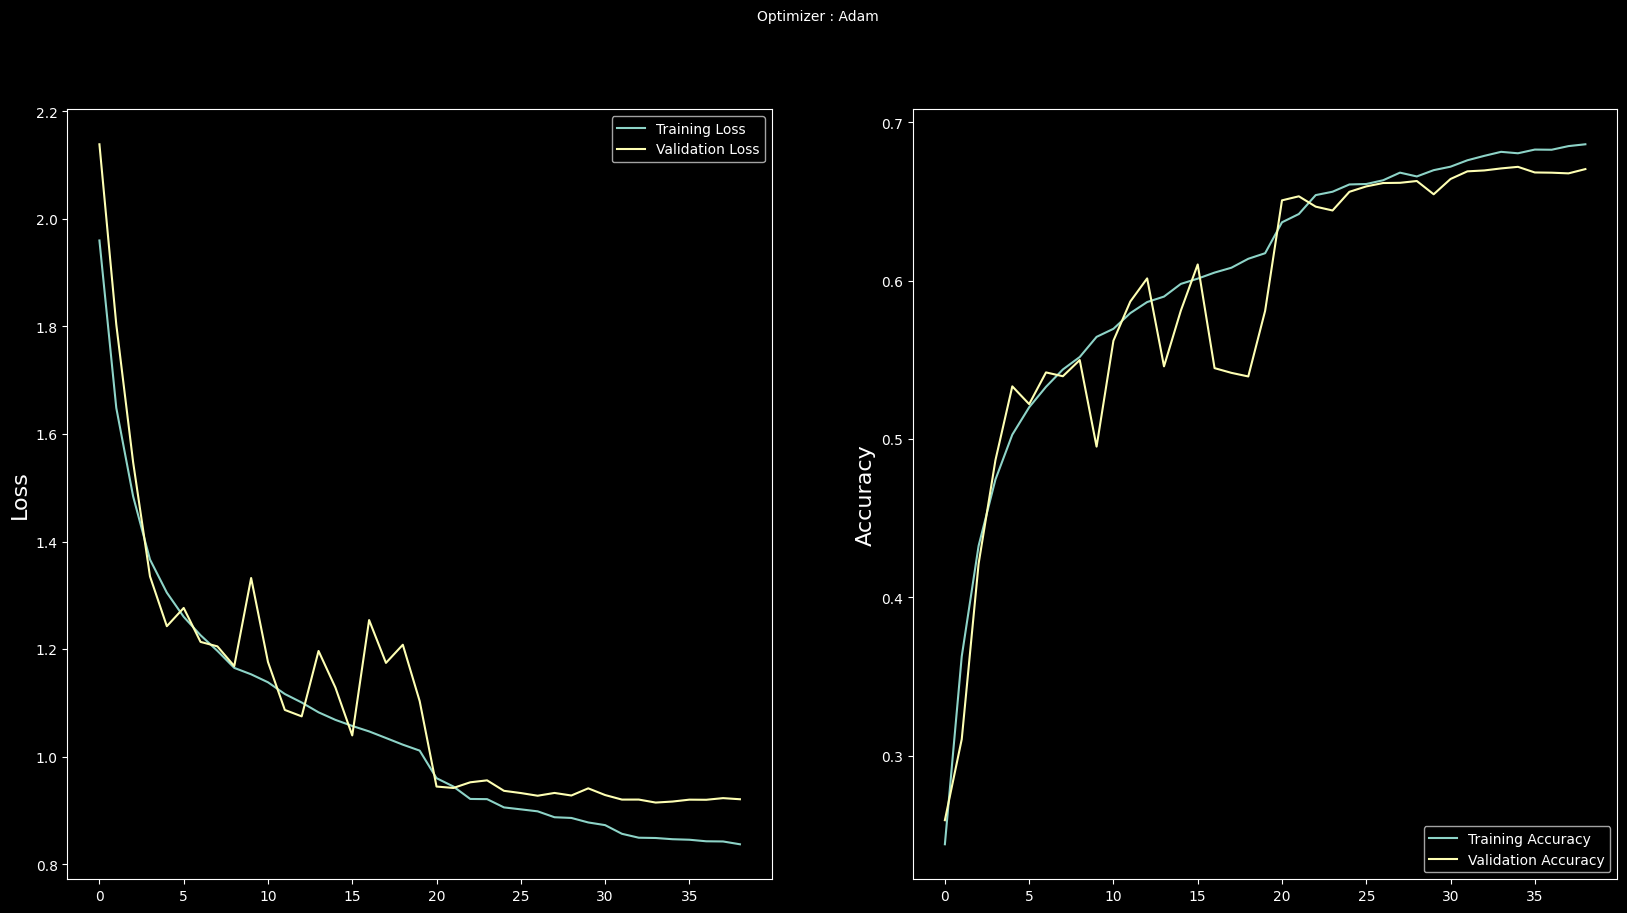

In [15]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_set.labels

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1score = f1_score(y_true, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1score)


56/56 [==============================] - 4s 63ms/step
Accuracy: 0.6712425700537786
Precision: 0.671401441618232
Recall: 0.6712425700537786
F1 score: 0.6677883024853748


In [17]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/my_models/fer_model8.h5')